# Benefit of Updating

Here we look at the FPR of models trained when there is a feedback loop, and without a feedback loop. We look at different types of model and different types of data. We want to show that there is a benefit when we are updating without feedback since otherwise the best thing to do would be keep our model static. I.e. we want to highlight the paradox that exists:

1. No feedback --> we want to update our model as often as possible to get better performance from larger sample size
2. Feedback --> want to keep model static/update less often to prevent runaway FPR

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import importlib

import src.models.sklearn
import src.utils.data
import src.utils.metrics
import src.utils.update

importlib.reload(src.models.sklearn)
importlib.reload(src.utils.data)
importlib.reload(src.utils.metrics)
importlib.reload(src.utils.update)

from src.models.sklearn import lr, linear_svm
from src.utils.data import generate_gaussian_dataset, generate_gaussian_quantile_dataset, generate_moons_dataset, generate_sklearn_make_classification_dataset
from src.utils.metrics import eval_model
from src.utils.update import update_model_feedback, update_model_no_feedback, update_model_full_fit_feedback, update_model_full_fit_no_feedback

%matplotlib inline    


In [10]:
def train_update_loop(n_train, n_update, n_test, num_updates, update_fn_feedback, update_fn_no_feedback, data_fn, model_fn, seeds):
    seeds = np.arange(seeds)
    initial_fprs = []
    updated_feedback_fprs = []
    updated_no_feedback_fprs = []
    gold_standard_fprs = []

    for seed in seeds:
        np.random.seed(seed)

        x_train, y_train, x_update, y_update, x_test, y_test = data_fn(n_train, n_update, n_test)

        base_model = model_fn()
        base_model.fit(x_train, y_train)

        y_pred = base_model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        if "full" in update_fn_feedback.__name__:
            updated_model_with_feedback, _ = update_fn_feedback(base_model, x_train, y_train, x_update, y_update, num_updates)
        else:
            updated_model_with_feedback, _ = update_fn_feedback(base_model, x_update, y_update, None, None, num_updates)

        y_pred = updated_model_with_feedback.predict(x_test)
        updated_feedback_tnr, updated_feedback_fpr, updated_feedback_fnr, updated_feedback_tpr = eval_model(y_test, y_pred)
        
        if "full" in update_fn_no_feedback.__name__:
            updated_model_without_feedback, _ = update_fn_no_feedback(base_model, x_train, y_train, x_update, y_update, num_updates)
        else:
            updated_model_without_feedback, _ = update_fn_no_feedback(base_model, x_update, y_update, None, None, num_updates)
        
        y_pred = updated_model_without_feedback.predict(x_test)
        updated_no_feedback_tnr, updated_no_feedback_fpr, updated_no_feedback_fnr, updated_no_feedback_tpr = eval_model(y_test, y_pred)
        
        gold_standard_model = model_fn()
        gold_standard_model.fit(np.concatenate((x_train, x_update)), np.concatenate((y_train, y_update)))
        
        y_pred = gold_standard_model.predict(x_test)
        gold_standard_tnr, gold_standard_fpr, gold_standard_fnr, gold_standrd_tpr = eval_model(y_test, y_pred)

        initial_fprs.append(initial_fpr)
        updated_feedback_fprs.append(updated_feedback_fpr)
        updated_no_feedback_fprs.append(updated_no_feedback_fpr)
        gold_standard_fprs.append(gold_standard_fpr)
        
    return initial_fprs, updated_feedback_fprs, updated_no_feedback_fprs, gold_standard_fprs

In [11]:
def boxplot(data, data_type, model_type):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    sns.boxplot(x="type", y="fpr", data=data, ax=ax)
    sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("FPR", size=20)
    ax.set_title("Initial vs. Updated FPRs {} on {} Data".format(model_type, data_type), size=26)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    fig.show()

In [24]:
seeds = 10
n_train = 1000
n_update = 1000
n_test = 1000

m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 0.5

num_updates = 100

In [36]:
model_fns = {"Logistic Regression": lr, "Linear SVM": linear_svm}
# model_fns = {"Logistic Regression": lr, "Linear SVM": linear_svm, "RBF SVM": rbf_svm}
update_fns = {"Logistic Regression": {"feedback": update_model_feedback, "no_feedback": update_model_no_feedback},
              "Linear SVM": {"feedback": update_model_feedback, "no_feedback": update_model_no_feedback},
              "RBF SVM": {"feedback": update_model_full_fit_feedback, "no_feedback": update_model_full_fit_no_feedback}}
data_fns = {"Gaussian": generate_gaussian_dataset(m0, m1, s0,s1, p0, p1), "Moons": generate_moons_dataset, 
            "Concentric Circles": generate_gaussian_quantile_dataset, 
            "sklearn Make Classification": generate_sklearn_make_classification_dataset}

In [37]:
results = {data_type: {model_type: {} for model_type in model_fns.keys()} for data_type in data_fns.keys()}

## Non Temporal

In [38]:
for data_type, data_fn in data_fns.items():
    for model_type, model_fn in model_fns.items():
        print(data_type)
        initial_fprs, updated_feedback_fprs, updated_no_feedback_fprs, gold_standard_fprs = train_update_loop(n_train, n_update, n_test, num_updates, 
                                                                                                              update_fns[model_type]["feedback"], 
                                                                                                              update_fns[model_type]["no_feedback"], 
                                                                                                              data_fn, model_fn, seeds)
        results[data_type][model_type]["initial_fprs"] = initial_fprs
        results[data_type][model_type]["updated_feedback_fprs"] = updated_feedback_fprs
        results[data_type][model_type]["updated_no_feedback_fprs"] = updated_no_feedback_fprs
        results[data_type][model_type]["gold_standard_fprs"] = gold_standard_fprs
        
        

Gaussian
Gaussian
Moons
Moons
Concentric Circles
Concentric Circles
sklearn Make  Classification
sklearn Make  Classification


In [39]:
data = {data_type: {model_type: None for model_type in model_fns.keys()} for data_type in data_fns.keys()}

for data_type in data_fns.keys():
    for model_type in model_fns.keys():
        
        temp = {"type": [], "fpr": []}
        for res_type in results[data_type][model_type].keys():
            temp["type"] += [res_type] * len(results[data_type][model_type][res_type])
            temp["fpr"] += results[data_type][model_type][res_type]
            
        data[data_type][model_type] = pd.DataFrame(temp)

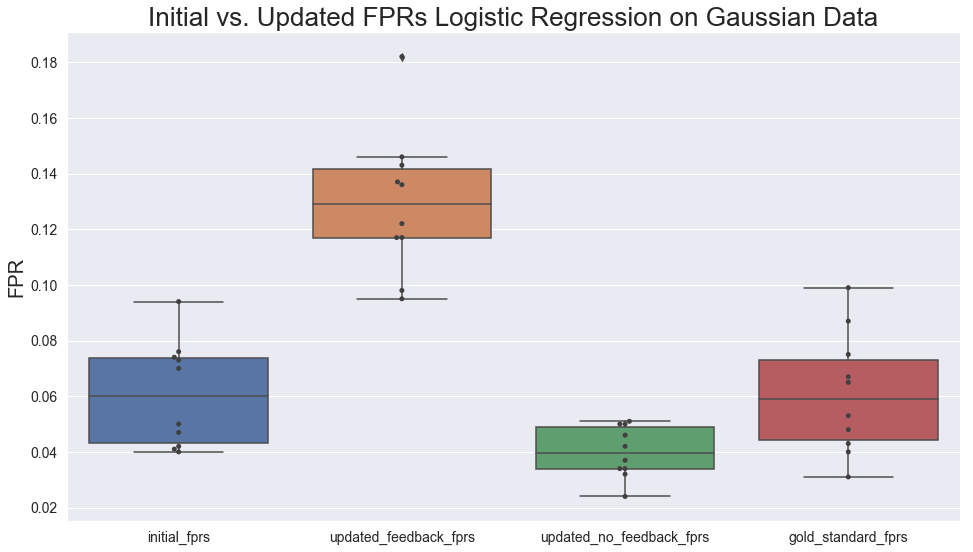

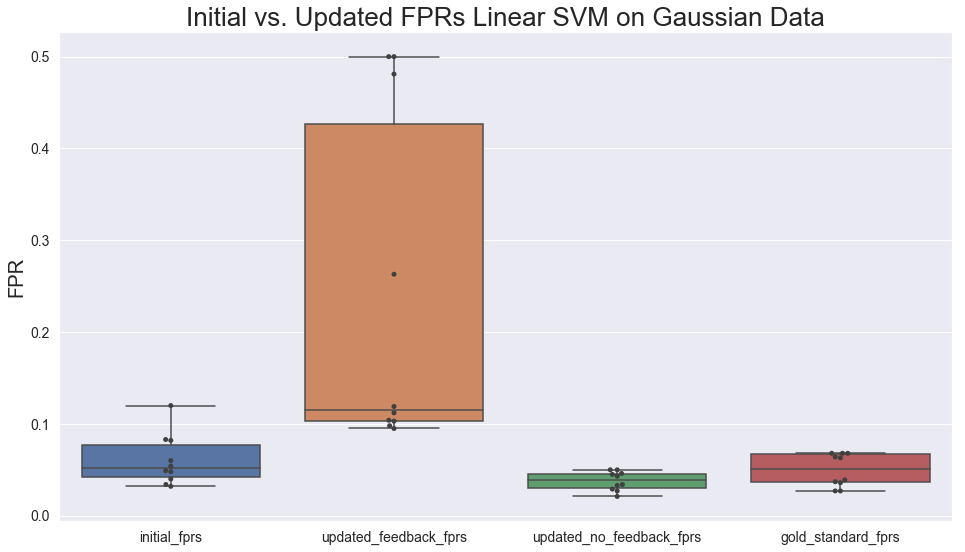

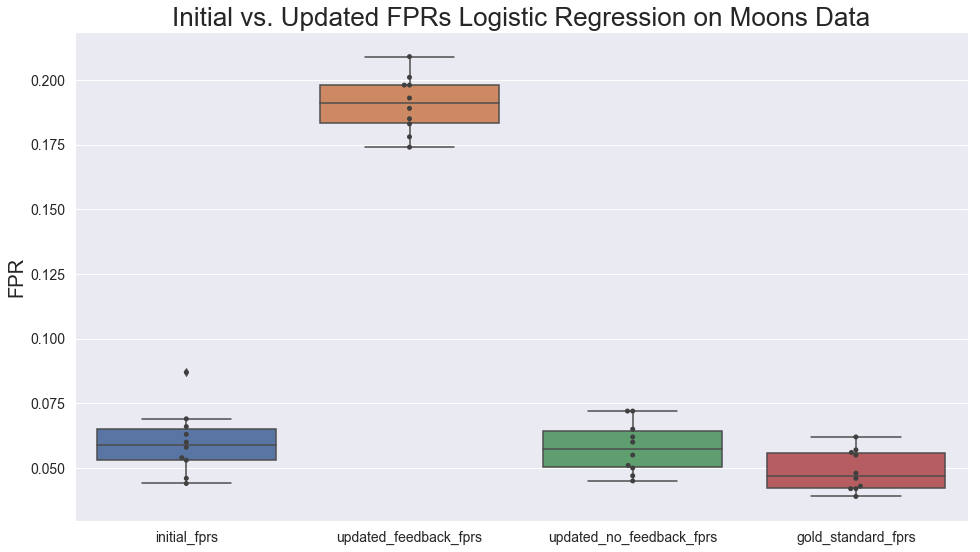

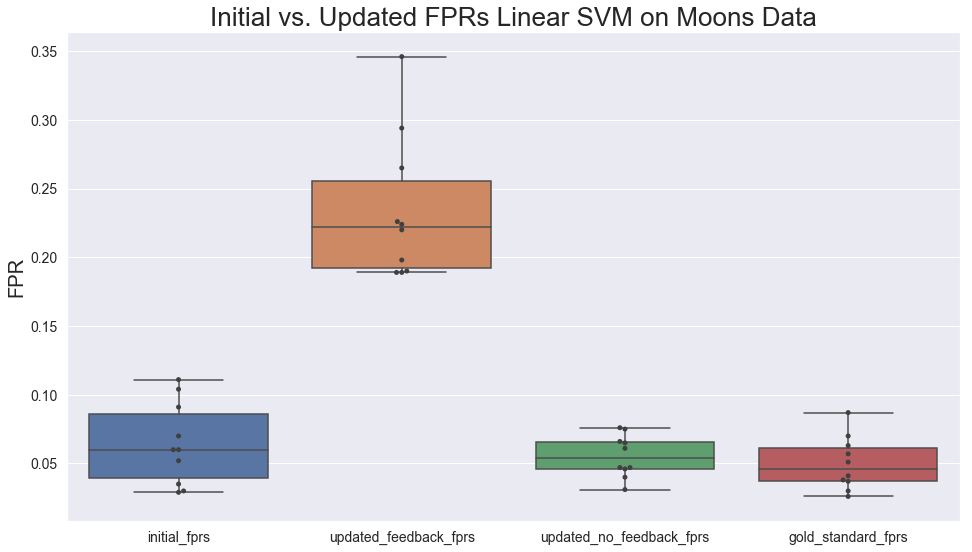

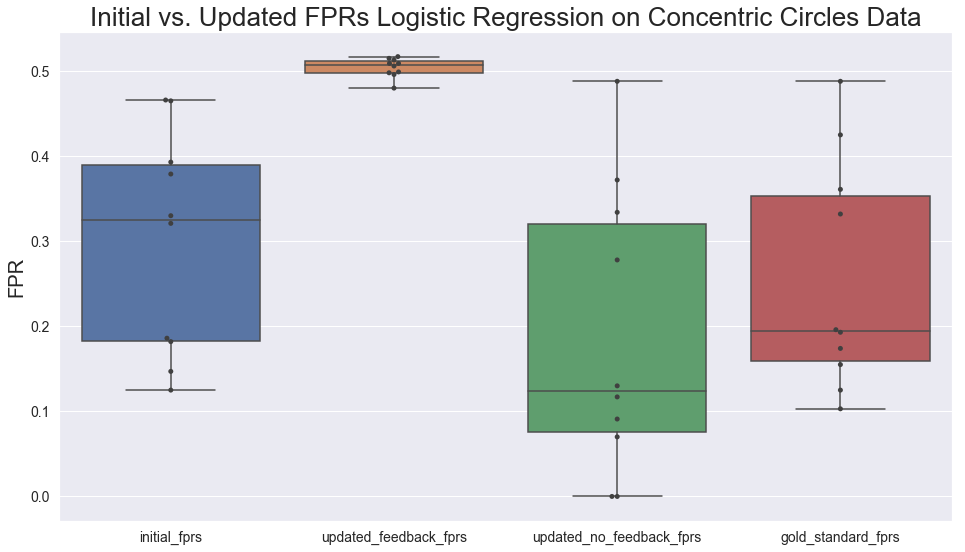

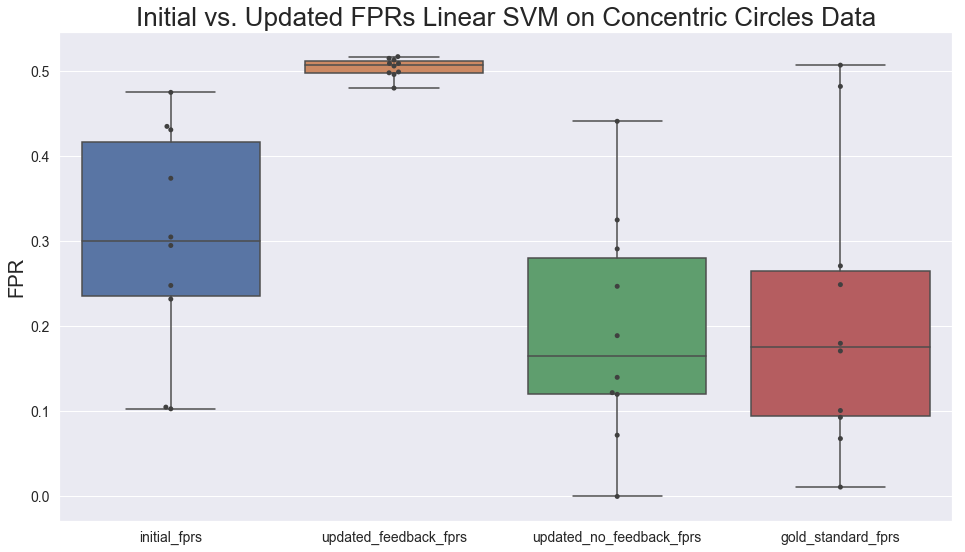

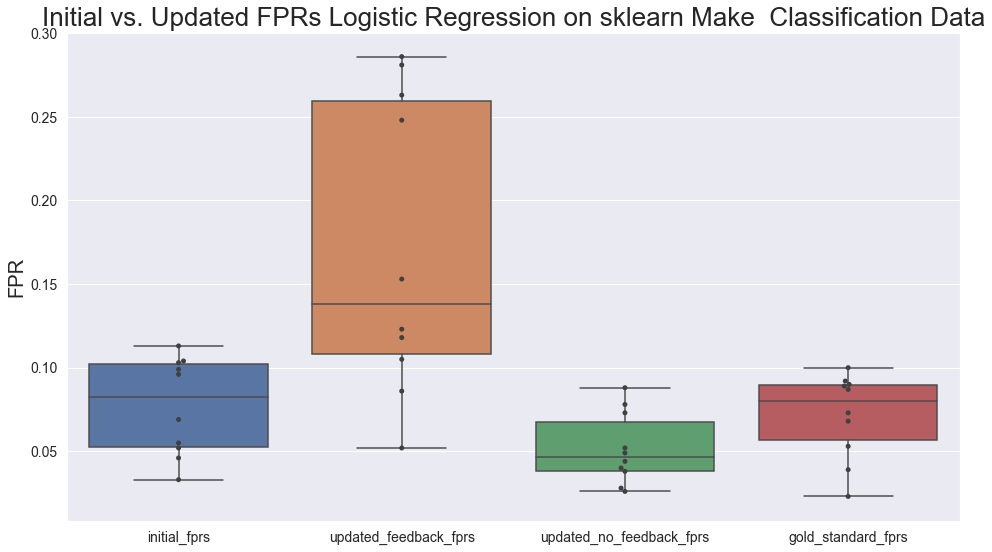

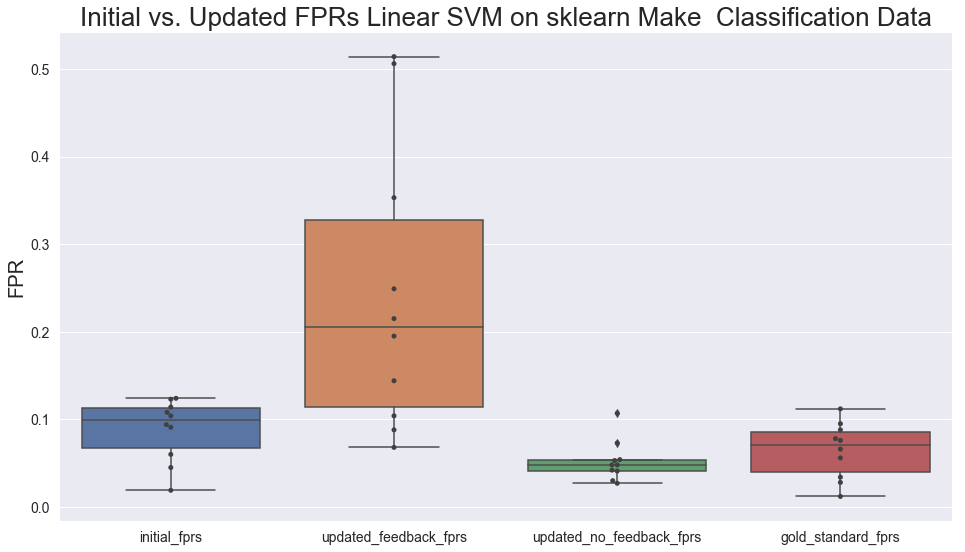

In [40]:
for data_type in data_fns.keys():
    for model_type in model_fns.keys():
        boxplot(data[data_type][model_type], data_type, model_type)

## Temporal